In [1]:
import random
import json
import multiprocessing as mp
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
np.seterr(divide="ignore", invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Correlation of fragment count

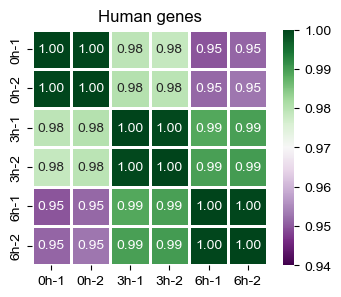

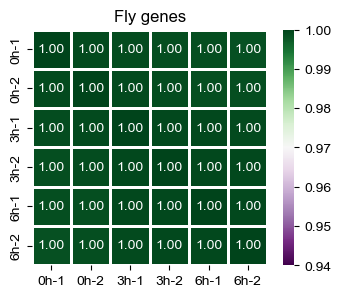

In [2]:
species_list = ["human", "fly"]
columns = ["0h-1", "0h-2", "3h-1", "3h-2", "6h-1", "6h-2"]

for species in species_list:
    samples = []
    for t in [0, 3, 6]:
        for r in [1, 2]:
            s = "20221128_K562_Actd_%dh_rep%d" % (t, r)
            samples.append(s)
    array = []
    for s, c in zip(samples, columns):
        path = "results/expression/fpkm/%s.%s.tsv" % (s, species)
        d = pd.read_csv(path, sep="\t", index_col=0)
        d = d[(d["GeneType"] == "protein_coding") & (d["Canonical"])]
        d = d[~d["GeneName"].duplicated()]
        ss = d["Count"]
        ss.name = c
        ss.index = d["GeneName"]
        array.append(ss)
    dat = pd.concat(array, axis=1)
    tmp = dat[dat.mean(axis=1) >= 100]
    corr = tmp.corr(method="pearson")
    vmin = 0.94
    plt.figure(figsize=(3.6, 3))
    if species == "human":
        plt.title("Human genes")
    else:
        plt.title("Fly genes")
    sns.heatmap(corr, cmap="PRGn", vmin=vmin, vmax=1, annot=True, fmt=".2f", lw=1, square=True)
    plt.tight_layout()
    plt.savefig("figures/fragment_count_corr.%s.pdf" % species, dpi=300)

# Estimation of conversion factor

In [3]:
columns = ["0h-1", "0h-2", "3h-1", "3h-2", "6h-1", "6h-2"]

samples = []
for time in [0, 3, 6]:
    for rep in [1, 2]:
        samples.append("20221128_K562_Actd_%dh_rep%d" % (time, rep))
        
array = []
for sample, column in zip(samples, columns):
    path = "results/expression/fpkm/%s.fly.tsv" % sample
    d = pd.read_csv(path, sep="\t", index_col=0)
    d = d[(d["GeneType"] == "protein_coding") & (d["Canonical"])]
    d = d[~d["GeneName"].duplicated()]
    s = d["Count"]
    s.name = column
    s.index = d["GeneName"]
    array.append(s)
m = pd.concat(array, axis=1)
m.to_csv("reports/counts_of_fly_genes.tsv", sep="\t")

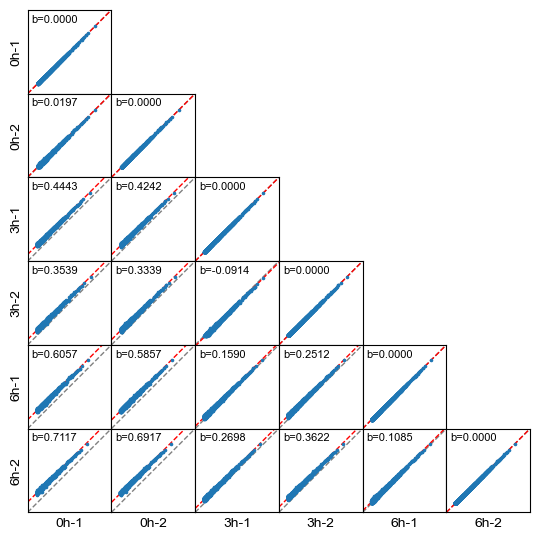

In [4]:
def get_k(xs, ys):
    xs = np.log(xs)
    ys = np.log(ys)
    b = (sum(ys) - sum(xs)) / len(xs)
    k = np.e ** b
    return k

def func(x, b):
    return x + b
    
dat = pd.read_csv("reports/counts_of_fly_genes.tsv", sep="\t", index_col=0)
factors = dict()
fig, axs = plt.subplots(len(columns), len(columns), figsize=(5.5, 5.5), gridspec_kw={"wspace": 0, "hspace": 0})
for i in range(len(columns)):
    for j in range(len(columns)):
        c1, c2 = columns[j], columns[i]
        xs, ys = dat[c1], dat[c2]
        flags = (xs > 500) & (ys > 500)
        xs, ys = xs[flags], ys[flags]
        k = get_k(xs, ys)
        b = np.log(k)
        xs, ys = np.log(xs), np.log(ys)

        # All R2 score > 0.99
        # popt, pcov = curve_fit(func, xs, ys)
        # print(popt, pcov)
        # r2 = r2_score(ys, [x + popt[0] for x in xs])
        # print(round(r2, 4))
        
        a1, b1 = np.polyfit(xs, ys, 1)
        vmin = min(min(xs), min(ys)) * 0.9
        vmax = max(max(xs), max(ys)) * 1.1
        factors["%s,%s" % (c1, c2)] = k
        if j > i:
            axs[i][j].set_visible(False)
            continue
        plt.sca(axs[i][j])
        plt.scatter(xs, ys, marker=".", alpha=1, color="C0", s=10, zorder=10)
        plt.xlim(vmin, vmax)
        plt.ylim(vmin, vmax)
        plt.plot([vmin, vmax], [vmin, vmax], ls="--", lw=1, color="grey")
        plt.plot([vmin, vmax], [vmin + b, vmax + b], ls="--", lw=1, color="red")
        w = vmax - vmin
        plt.text(vmin + w * 0.05, vmin + w * 0.85, "b=%.4f" % b, size=8)
        if i == len(columns) - 1:
            plt.xlabel(c1)
        else:
            plt.xticks([])
        if j == 0:
            plt.ylabel(c2)
        else:
            plt.yticks([])
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
plt.savefig("figures/scatter_of_conversion_factor.pdf")
with open("reports/conversion_factors.json", "w+") as fw:
    json.dump(factors, fw, indent=4)

# Estimation of half-life

In [11]:
def halflife_from_linear_fitting(ys0):
        T = np.nan
        R = np.nan # R2 score
        try:
            xs0 = np.array([0, 0, 3, 3, 6, 6])
            ys = ys0[2:]
            xs = xs0[2:]
            Y = np.log2(-np.log2(ys))
            X = np.log2(xs)
            b = sum(Y - X) / len(Y)
            T = 1 / (2 ** b)
            R = r2_score(ys0, np.array([2**(-x/T) for x in xs0]))
        except ValueError:
            pass
        return T, R

def decay_curve(t, T):
    return 2 ** (-t/T)

def halflife_from_curve_fitting(ys0):
    T = np.nan
    R = np.nan
    try:
        xs0 = np.array([0, 0, 3, 3, 6, 6])
        popt, pcov = curve_fit(decay_curve, xs0, ys0, bounds=(0, np.inf))
        T = popt[0]
        R = r2_score(ys0, np.array([decay_curve(x, T) for x in xs0]))
    except Exception:
        pass
    return T, R

## Half-life of genes

In [ ]:
anno = pd.read_csv("/home/chenzonggui/species/homo_sapiens/GRCh38.p13/gencode.v39.annotation.tsv", sep="\t", index_col=0)
columns = ["0h-1", "0h-2", "3h-1", "3h-2", "6h-1", "6h-2"]
samples = []
for t in [0, 3, 6]:
    for r in [1, 2]:
        samples.append("20221128_K562_Actd_%dh_rep%d" % (t, r))
        
array = []
for sample, c in zip(samples, columns):
    path = "results/expression/fpkm/%s.human.tsv" % sample
    df = pd.read_csv(path, sep="\t", index_col=0)
    s = df["FPKM"]
    s.name = "FPKM.%s" % c
    array.append(s)
    s = df["Count"]
    s.name = "Count.%s" % c
    array.append(s)
df = pd.concat(array, axis=1)
df = df[list(sorted(df.columns))]

# normalized
factors = json.load(open("reports/conversion_factors.json"))
for c in columns:
    factor = factors["%s,%s" % (c, "0h-1")]
    df["Count.%s.norm" % c] = df["Count.%s" % c] * factor

# relative abundance
mean_0 = df[["Count.0h-1.norm", "Count.0h-2.norm"]].mean(axis=1)
for c in columns:
    df["Abundance.%s" % c] = df["Count.%s.norm" % c] / mean_0

# linear fitting
if False:
    Ts = []
    Rs = []
    for ys0 in df[["Abundance.%s" % c for c in columns]].values:
        T, R = halflife_from_linear_fitting(ys0)
        Ts.append(T)
        Rs.append(R)
    df["T"] = Ts
    df["R2.Score"] = Rs
    
# curve fitting
if True:
    Ts = []
    Rs = []
    for ys0 in df[["Abundance.%s" % c for c in columns]].values:
        T, R = halflife_from_curve_fitting(ys0)
        Ts.append(T)
        Rs.append(R)
    df["T"] = Ts
    df["R2.Score"] = Rs
    
df = df.merge(anno, left_index=True, right_index=True)
df.to_csv("reports/halflife_of_k562_genes.tsv", sep="\t")

## Half-life of introns

In [20]:
columns = ["0h-1", "0h-2", "3h-1", "3h-2", "6h-1", "6h-2"]
paths = [
    "results/introns/counts/20221128_K562_Actd_0h_rep1.tsv",
    "results/introns/counts/20221128_K562_Actd_0h_rep2.tsv",
    "results/introns/counts/20221128_K562_Actd_3h_rep1.tsv",
    "results/introns/counts/20221128_K562_Actd_3h_rep2.tsv",
    "results/introns/counts/20221128_K562_Actd_6h_rep1.tsv",
    "results/introns/counts/20221128_K562_Actd_6h_rep2.tsv"]

# counts
array = []
motifs = dict()
knowns = dict()
for c, path in zip(columns, paths):
    d = pd.read_csv(path, sep="\t")
    ks = []
    for chrom, start, end, strand, motif, known in d[["Chrom", "Start", "End", "Strand", "Motif", "Known"]].values:
        k = (chrom, start, end, strand)
        ks.append(k)
        motifs[k] = motif
        knowns[k] = known
    s = d["Count"]
    s.index = ks
    s.name = "Count.%s" % c
    array.append(s)        
dat = pd.concat(array, axis=1).fillna(0).astype(int)

# normalized
factors = json.load(open("reports/conversion_factors.json"))
for c in columns:
    x = factors["%s,%s" % (c, "0h-1")]
    dat["Count.%s.norm" % c] = dat["Count.%s" % c] * x

# abundance
for c in columns:
    dat["Abundance.%s" % c] = dat["Count.%s.norm" % c] / dat[["Count.0h-1.norm", "Count.0h-2.norm"]].mean(axis=1)

dat["Chrom"] = [idx[0] for idx in dat.index]
dat["Start"] = [idx[1] for idx in dat.index]
dat["End"] = [idx[2] for idx in dat.index]
dat["Strand"] = [idx[3] for idx in dat.index]
dat["Motif"] = dat.index.map(motifs)
dat["Known"] = dat.index.map(knowns)

if True:
    Ts = []
    Rs = []
    for ys0 in dat[["Abundance.%s" % c for c in columns]].values:
        T, R = halflife_from_curve_fitting(ys0)
        Ts.append(T)
        Rs.append(R)
    dat["T"] = Ts
    dat["R2.Score"] = Rs

dat.to_csv("reports/halflife_of_introns.tsv", sep="\t", index=False)

# Plot decay curve of star genes

MYC, PDLIM5, ACTB, GAPDH

MYC
Abundance.0h-1    0.990175
Abundance.0h-2    1.009825
Abundance.3h-1    0.020976
Abundance.3h-2    0.021567
Abundance.6h-1    0.013179
Abundance.6h-2    0.012228
Name: ENST00000621592.8, dtype: object
PDLIM5
Abundance.0h-1     1.00851
Abundance.0h-2     0.99149
Abundance.3h-1    0.624902
Abundance.3h-2    0.640381
Abundance.6h-1    0.472935
Abundance.6h-2    0.501054
Name: ENST00000317968.9, dtype: object
ACTB
Abundance.0h-1    0.988255
Abundance.0h-2    1.011745
Abundance.3h-1    0.800109
Abundance.3h-2    0.835466
Abundance.6h-1    0.653547
Abundance.6h-2    0.651801
Name: ENST00000646664.1, dtype: object
GAPDH
Abundance.0h-1     0.98833
Abundance.0h-2     1.01167
Abundance.3h-1     0.92879
Abundance.3h-2    0.979032
Abundance.6h-1    0.866606
Abundance.6h-2     0.83682
Name: ENST00000229239.10, dtype: object


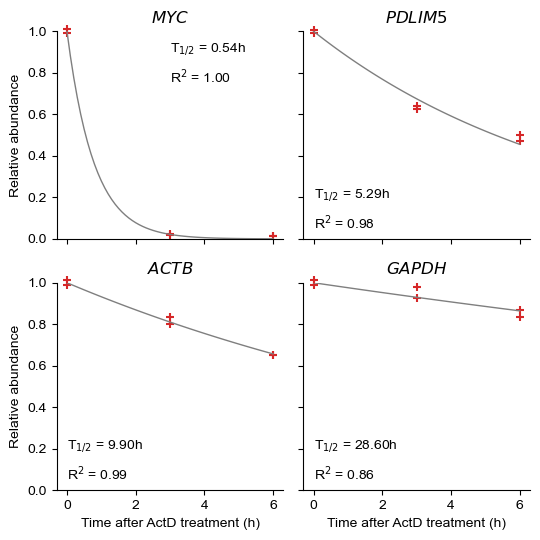

In [21]:
df = pd.read_csv("reports/halflife_of_k562_genes.tsv", sep="\t", index_col=0)
columns = ["0h-1", "0h-2", "3h-1", "3h-2", "6h-1", "6h-2"]
tids = [
    "ENST00000621592.8", # MYC
    "ENST00000317968.9", # PDLIM5
    "ENST00000646664.1", # ACTB
    "ENST00000229239.10", # GAPDH
]

fig, axs = plt.subplots(2, 2, figsize=(5.5, 5.5), sharex=True, sharey=True)
for i, tid in enumerate(tids):
    m = int(i / 2)
    n = i % 2
    plt.sca(axs[m][n])
    
    T = df.loc[tid]["T"]
    D = df.loc[tid]["R2.Score"]
    gname = df.loc[tid]["GeneName"]
    xs = np.array([0, 0, 3, 3, 6, 6])
    ys = df.loc[tid][["Abundance.%s" % c for c in columns]]
    print(gname)
    print(ys)
    xs1 = np.arange(0, 6.1, 0.1)
    ys1 = np.array([0.5**(x/T)for x in xs1])
    
    plt.title("$\it{%s}$" % gname)
    plt.scatter(xs, ys, color="C3", marker="+", clip_on=False)
    plt.plot(xs1, ys1, lw=1, color="C7")
    if gname == "MYC":
        plt.text(3, 0.9, "T$_{1/2}$ = %.2fh" % T)
        plt.text(3, 0.75, "R$^2$ = %.2f" % D)
    else:
        plt.text(0, 0.2, "T$_{1/2}$ = %.2fh" % T)
        plt.text(0, 0.05, "R$^2$ = %.2f" % D)
    if m == 1:
        plt.xlabel("Time after ActD treatment (h)")
    if n == 0:
        plt.ylabel("Relative abundance")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("figures/decay_curve.example_genes.pdf", dpi=300)

# Allele-specific decay diversity

TODO!

In [45]:
data_factors = json.load(open("results/transform_factor.json"))
dates = ["20221128", "20221205"]
columns = ["0h-1", "0h-2", "3h-1", "3h-2", "6h-1", "6h-2"]

date = dates[0]
samples = []
for t in [0, 3, 6]:
    for r in [1, 2]:
        s = "%s_K562_Actd_%dh_rep%d" % (date, t, r)
        samples.append(s)
array = []
for sample, column in zip(samples, columns):
    d = pd.read_csv("results/snps/counts/%s.tsv" % sample, sep="\t")
    d.index = ["%s:%d" % (chrom, start) for chrom, start in d[["Chrom", "Start"]].values]
    d = d[d.columns[3:]]
    d.columns = ["%s_%s" % (column, c) for c in d.columns]
    array.append(d)
df = pd.concat(array, axis=1, join="outer").fillna(0)

In [80]:
for hp in ["HP1", "HP2"]:
    for column in columns:
        factor = data_factors[date]["%s,0h-1" % column]
        # df["%s_%s" % (column, hp)] * factor
        df["%s_%s_adj" % (column, hp)] = df["%s_%s" % (column, hp)] * factor
        
    mean_0 =  df[["0h-1_%s_adj" % hp, "0h-2_%s_adj" % hp]].mean(axis=1)
    for column in columns:
        df["%s_%s_adj_p" % (column, hp)] = df["%s_%s_adj" % (column, hp)] / mean_0
        
    Ts = []
    Ds = []
    for vs in df[[c + "_%s_adj_p" % hp for c in columns]].values:
        xs0 = [0, 0, 3, 3, 6, 6]
        ys0 = vs
        ys = ys0[2:]
        xs = np.array([3, 3, 6, 6])
        Y = np.log2(-np.log2(ys))
        X = np.log2(xs)
        b = sum(Y - X) / len(Y)
        T = 1 / (2 ** b)
        D = sum([abs(y - 2 ** (-x/T)) for x, y in zip(xs0, ys0)])
        Ts.append(T)
        Ds.append(D)
    df["T_%s" % hp] = Ts
    df["D_%s" % hp] = Ds
    df["P_Nascent_%s" % hp] = 1 - 0.5 ** (3 / df["T_%s" % hp])
    df["K_%s" % hp] = mean_0 / df["T_%s" % hp] * np.log(2)

/home/chenzonggui/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log2
/home/chenzonggui/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log2
/home/chenzonggui/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
/home/chenzonggui/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


In [81]:
df1 = df[(df["0h-1_Assigned%"] > 0.95) & (df["0h-2_Assigned%"] > 0.95)] # assigned
df1 = df1[(df1["0h-1_Log2FC"].abs() < 2) & (df1["0h-2_Log2FC"].abs() < 2)]
df1 = df1[(df1["D_HP1"] < 0.2) & (df1["D_HP2"] < 0.2)]
df1

,0h-1_UnAssinged,0h-1_HP1,0h-1_HP2,0h-1_Assigned,0h-1_Assigned%,0h-1_Log2FC,0h-2_UnAssinged,0h-2_HP1,0h-2_HP2,0h-2_Assigned,...,6h-1_HP2_adj_p,6h-2_HP2_adj_p,T_HP1,D_HP1,T_HP2,D_HP2,P_Nascent_HP1,P_Nascent_HP2,K_HP1,K_HP2
chr1:2308943,0,38,33,71,1.000000,0.203533,1,38,36,74,...,0.032133,0.043604,1.443515,0.053451,1.409918,0.166829,0.763200,0.771191,18.041512,16.761817
chr1:42926578,2,213,354,567,0.996485,-0.732896,1,210,338,548,...,0.118457,0.121645,2.002636,0.079319,2.016026,0.103092,0.645962,0.643512,72.385907,117.653544
chr1:42929963,0,212,277,489,1.000000,-0.385822,0,218,316,534,...,0.117804,0.130256,1.847667,0.105555,2.127734,0.192365,0.675491,0.623675,79.736362,95.431741
chr1:42930742,2,195,301,496,0.995984,-0.626289,1,210,321,531,...,0.167512,0.132196,2.042205,0.111158,2.157529,0.176763,0.638767,0.618562,67.928684,98.754181
chr1:65392461,0,100,39,139,1.000000,1.358454,0,92,42,134,...,0.095796,0.061902,1.449124,0.172438,1.567438,0.140376,0.761876,0.734635,45.423662,17.700770
chr1:150966094,4,428,233,661,0.993985,0.877281,4,446,233,679,...,0.661010,0.613049,8.150978,0.091018,10.496497,0.177152,0.225173,0.179719,36.735046,15.213257
chr1:203852185,0,106,53,159,1.000000,1.000000,0,113,54,167,...,0.176060,0.215490,2.780268,0.129937,2.360902,0.107709,0.526654,0.585542,26.982371,15.528887
chr1:230281203,3,56,138,194,0.984772,-1.301170,2,57,130,187,...,0.661282,0.646845,20.126840,0.168276,8.933353,0.170509,0.098159,0.207666,1.923711,10.283679
chr1:230281917,0,35,91,126,1.000000,-1.378512,0,36,96,132,...,0.628269,0.697060,7.428705,0.139864,9.119671,0.158591,0.244156,0.203889,3.274585,7.024428
chr1:241872135,0,139,56,195,1.000000,1.311586,0,137,55,192,...,0.119774,0.117385,2.042249,0.124094,1.727890,0.183848,0.638760,0.699845,46.314500,22.015685


limit_output extension: Maximum message size of 10000 exceeded with 31699 characters

In [82]:
df1[["0h-1_HP1_adj", "0h-2_HP1_adj", "0h-1_HP2_adj", "0h-2_HP2_adj", "T_HP1", "T_HP2", "P_Nascent_HP1", "P_Nascent_HP2"]]

,0h-1_HP1_adj,0h-2_HP1_adj,0h-1_HP2_adj,0h-2_HP2_adj,T_HP1,T_HP2,P_Nascent_HP1,P_Nascent_HP2
chr1:2308943,38.0,37.144779,33.0,35.189791,1.443515,1.409918,0.763200,0.771191
chr1:42926578,213.0,205.273781,354.0,330.393038,2.002636,2.016026,0.645962,0.643512
chr1:42929963,212.0,213.093735,277.0,308.888166,1.847667,2.127734,0.675491,0.623675
chr1:42930742,195.0,205.273781,301.0,313.775637,2.042205,2.157529,0.638767,0.618562
chr1:65392461,100.0,89.929466,39.0,41.054756,1.449124,1.567438,0.761876,0.734635
chr1:150966094,428.0,435.962411,233.0,227.756148,8.150978,10.496497,0.225173,0.179719
chr1:203852185,106.0,110.456844,53.0,52.784687,2.780268,2.360902,0.526654,0.585542
chr1:230281203,56.0,55.717169,138.0,127.074245,20.126840,8.933353,0.098159,0.207666
chr1:230281917,35.0,35.189791,91.0,93.839443,7.428705,9.119671,0.244156,0.203889
chr1:241872135,139.0,133.916705,56.0,53.762181,2.042249,1.727890,0.638760,0.699845


limit_output extension: Maximum message size of 10000 exceeded with 15089 characters

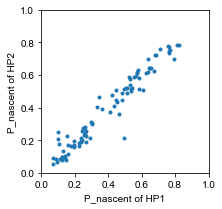

In [83]:
xs = df1["P_Nascent_HP1"]
ys = df1["P_Nascent_HP2"]
plt.figure(figsize=(3, 3))
plt.scatter(xs, ys, marker=".")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("P_nascent of HP1")
plt.ylabel("P_nascent of HP2")
plt.show()

In [85]:
df1[df1["P_Nascent_HP1"] / df1["P_Nascent_HP2"] > 2].iloc[0]

0h-1_UnAssinged      2.000000
0h-1_HP1           165.000000
0h-1_HP2            65.000000
0h-1_Assigned      230.000000
0h-1_Assigned%       0.991379
0h-1_Log2FC          1.343954
0h-2_UnAssinged      6.000000
0h-2_HP1           187.000000
0h-2_HP2            66.000000
0h-2_Assigned      253.000000
0h-2_Assigned%       0.976834
0h-2_Log2FC          1.502500
3h-1_UnAssinged      5.000000
3h-1_HP1           145.000000
3h-1_HP2            80.000000
3h-1_Assigned      225.000000
3h-1_Assigned%       0.978261
3h-1_Log2FC          0.857981
3h-2_UnAssinged      2.000000
3h-2_HP1           120.000000
3h-2_HP2            72.000000
3h-2_Assigned      192.000000
3h-2_Assigned%       0.989691
3h-2_Log2FC          0.736966
6h-1_UnAssinged      4.000000
6h-1_HP1            82.000000
6h-1_HP2            75.000000
6h-1_Assigned      157.000000
6h-1_Assigned%       0.975155
6h-1_Log2FC          0.128733
                      ...    
3h-1_HP1_adj        93.253383
3h-2_HP1_adj        84.084285
6h-1_HP1_a

In [2]:
m = pd.read_csv("results/snps/counts/20221128_K562_Actd_0h_rep1.tsv", sep="\t")
m

,Chrom,Start,End,UnAssinged,HP1,HP2,Assigned,Assigned%,Log2FC
0,chr1,14652,14653,1,47,16,63,0.984375,1.554589
1,chr1,15188,15189,2,11,5,16,0.888889,1.137504
2,chr1,15203,15204,2,11,6,17,0.894737,0.874469
3,chr1,15819,15820,3,11,8,19,0.863636,0.459432
4,chr1,16724,16725,4,33,14,47,0.921569,1.237039
...,...,...,...,...,...,...,...,...,...
16833,chrY,11155880,11155881,14,6,32,38,0.730769,-2.415037
16834,chrY,11163092,11163093,15,24,89,113,0.882812,-1.890771
16835,chrY,11209744,11209745,52,48,96,144,0.734694,-1.000000
16836,chrY,11214965,11214966,32,51,82,133,0.806061,-0.685127


(array([1200.,  486.,  390.,  385.,  394.,  511.,  708.,  992., 1937.,
        9835.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

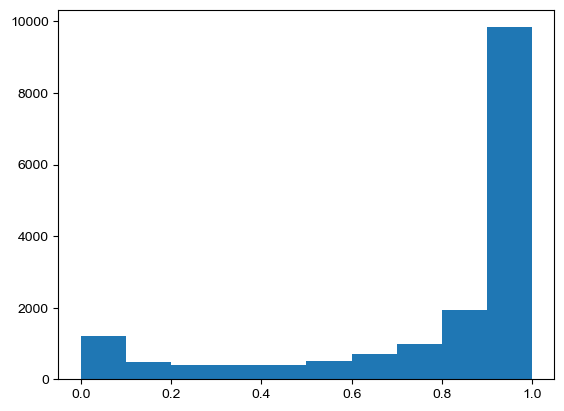

In [4]:
plt.hist(m["Assigned%"])